# Main results

Reproduce the key figures: time series and healthspan vs lifespan scatter across interventions.

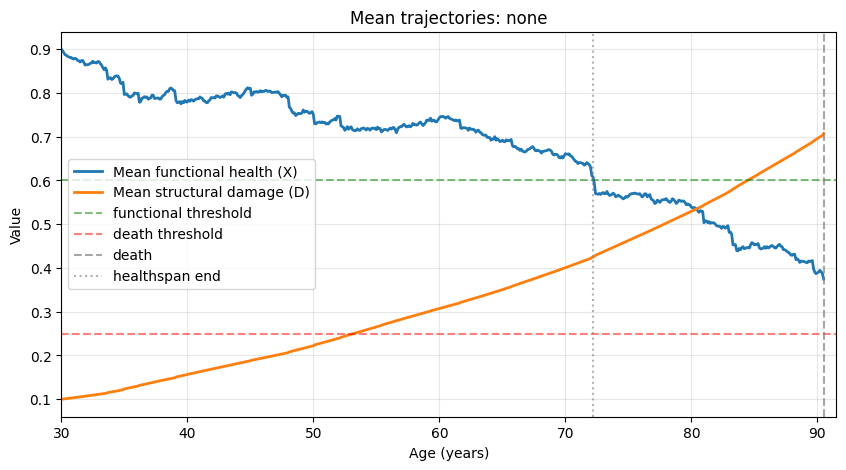

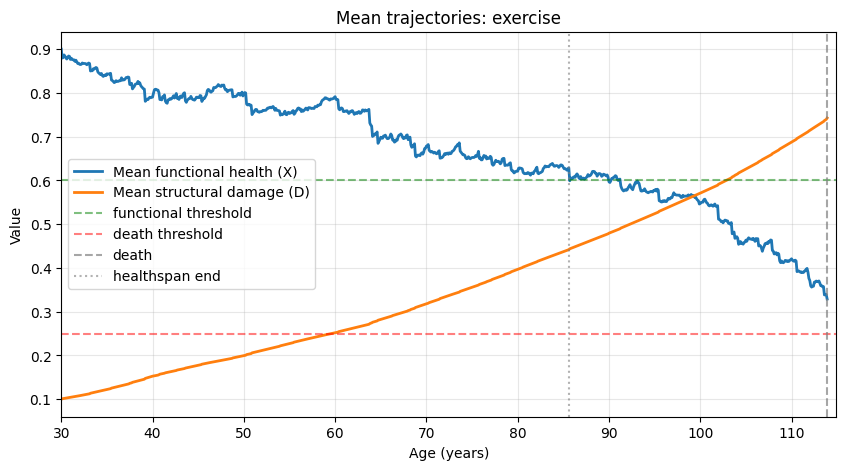

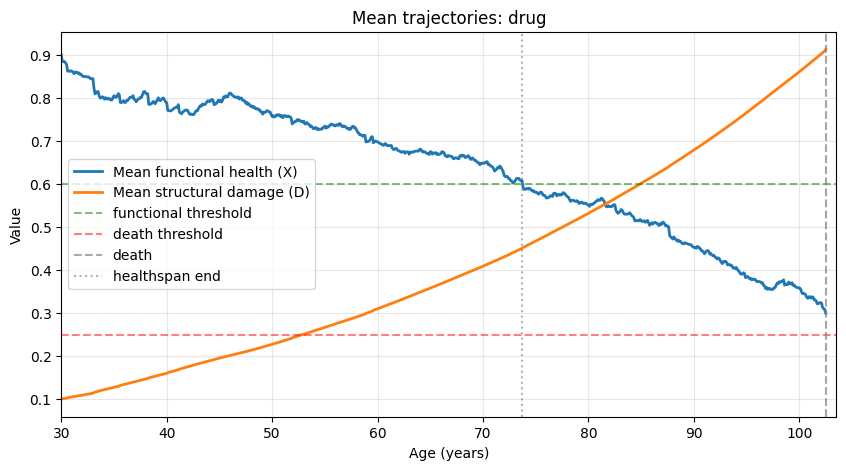

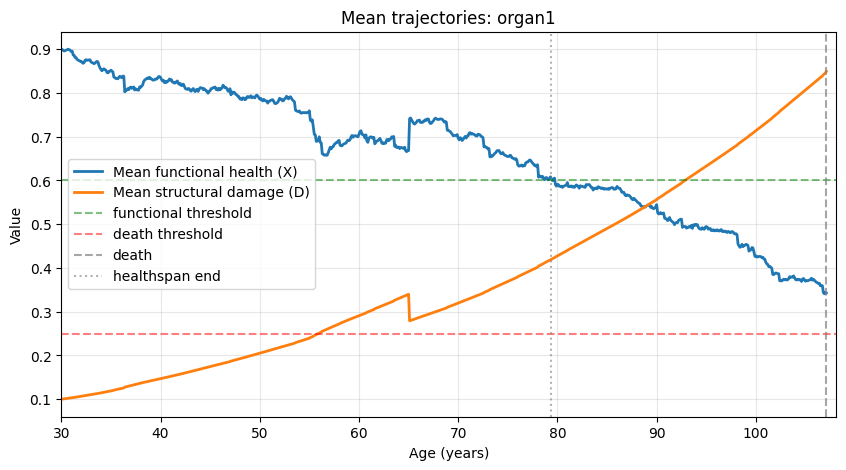

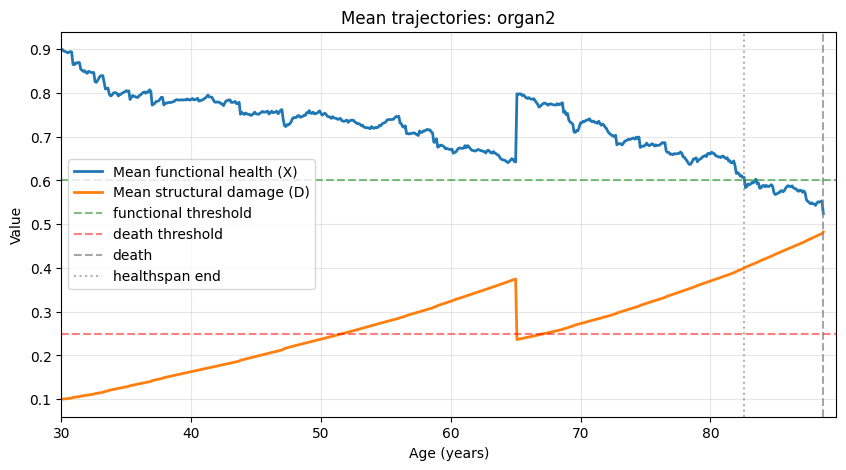

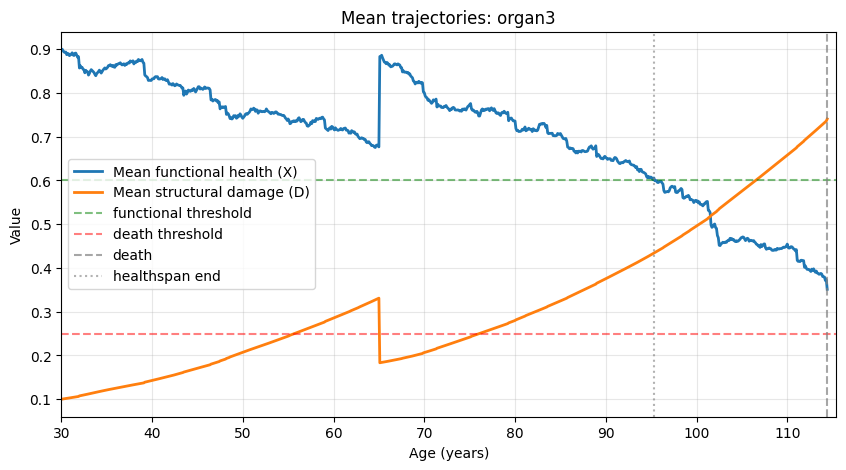

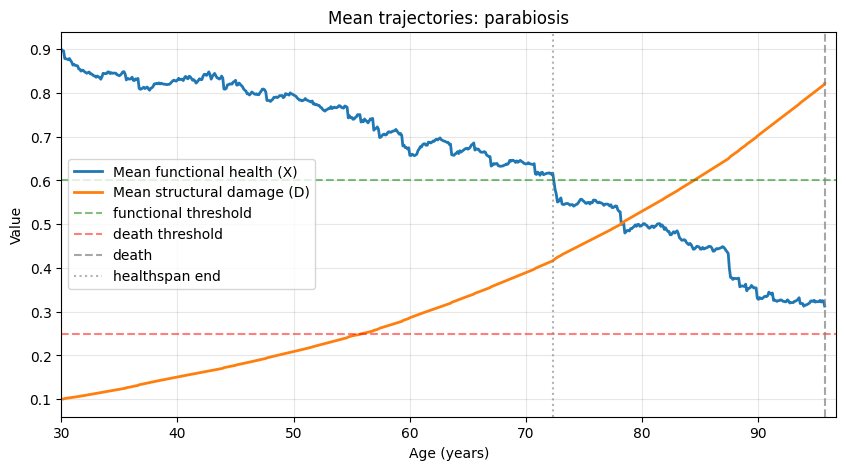

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from aging_network import (
    DEFAULT_SCENARIOS,
    default_simulation_config,
    default_system_config,
    plot_healthspan_vs_lifespan,
    plot_mean_X_D_over_time,
    run_many,
    run_sim,
)

sim_cfg = default_simulation_config()
system_cfg = default_system_config()
node_names = system_cfg.node_names
color_map = {
    "none": "black",
    "exercise": "green",
    "drug": "blue",
    "organ1": "orange",
    "organ2": "darkorange",
    "organ3": "gold",
    "parabiosis": "purple",
}

single_results = {
    mode: run_sim(mode, sim_config=sim_cfg, system_config=system_cfg)
    for mode in DEFAULT_SCENARIOS
}

for mode, res in single_results.items():
    plot_mean_X_D_over_time(
        res,
        func_threshold=sim_cfg.func_threshold,
        death_threshold=sim_cfg.death_threshold,
        title=f"Mean trajectories: {mode}",
    )
plt.show()


## Aggregate mean functional health

Compare functional trajectories across key intervention groups.

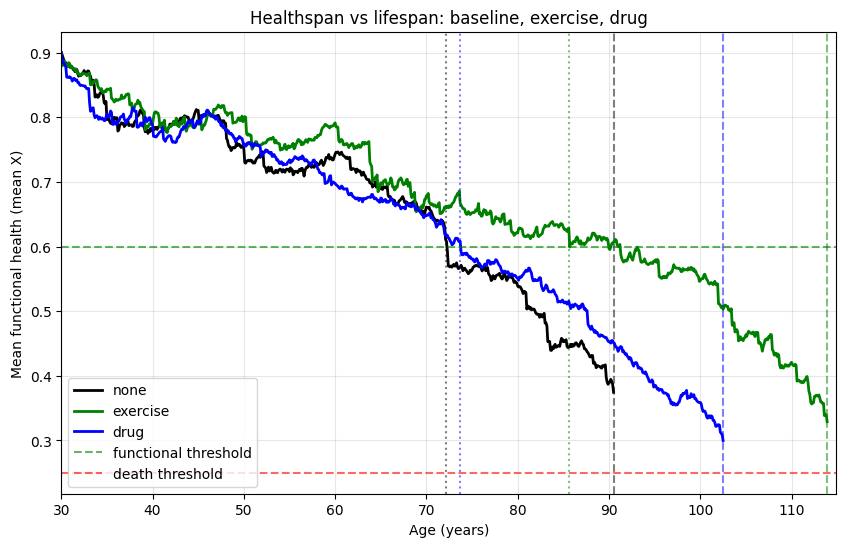

In [4]:

# Aggregate mean functional health: baseline vs exercise vs drug
compare1 = ["none", "exercise", "drug"]

plt.figure(figsize=(10, 6))
for mode in compare1:
    res = single_results[mode]
    mean_X = res.X_hist.mean(axis=1)
    plt.plot(
        res.age,
        mean_X,
        label=mode,
        color=color_map.get(mode),
        linewidth=2,
    )
    if res.healthspan is not None:
        plt.axvline(res.healthspan, color=color_map.get(mode), linestyle=":", alpha=0.5)
    if res.lifespan is not None:
        plt.axvline(res.lifespan, color=color_map.get(mode), linestyle="--", alpha=0.5)

plt.axhline(sim_cfg.func_threshold, color="green", linestyle="--", alpha=0.6, label="functional threshold")
plt.axhline(sim_cfg.death_threshold, color="red", linestyle="--", alpha=0.6, label="death threshold")

max_death_age = max(
    (single_results[m].lifespan for m in compare1 if single_results[m].lifespan is not None),
    default=sim_cfg.start_age + sim_cfg.years,
)
plt.xlim(sim_cfg.start_age, max_death_age + 1.0)
plt.xlabel("Age (years)")
plt.ylabel("Mean functional health (mean X)")
plt.title("Healthspan vs lifespan: baseline, exercise, drug")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


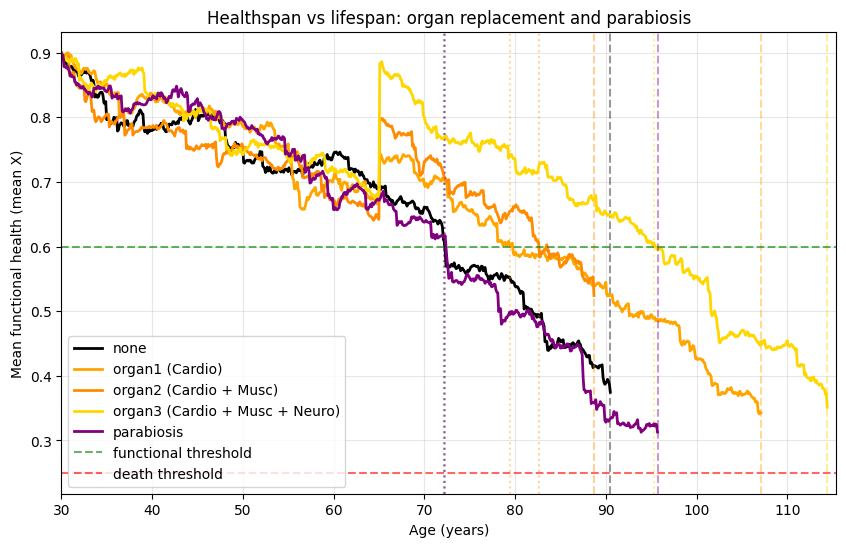

In [5]:

# Aggregate mean functional health: organ replacement and parabiosis scenarios
compare2 = ["none", "organ1", "organ2", "organ3", "parabiosis"]
labels = {
    "none": "none",
    "organ1": "organ1 (Cardio)",
    "organ2": "organ2 (Cardio + Musc)",
    "organ3": "organ3 (Cardio + Musc + Neuro)",
    "parabiosis": "parabiosis",
}

plt.figure(figsize=(10, 6))
for mode in compare2:
    res = single_results[mode]
    mean_X = res.X_hist.mean(axis=1)
    plt.plot(
        res.age,
        mean_X,
        label=labels.get(mode, mode),
        color=color_map.get(mode),
        linewidth=2,
    )
    if res.healthspan is not None:
        plt.axvline(res.healthspan, color=color_map.get(mode), linestyle=":", alpha=0.4)
    if res.lifespan is not None:
        plt.axvline(res.lifespan, color=color_map.get(mode), linestyle="--", alpha=0.4)

plt.axhline(sim_cfg.func_threshold, color="green", linestyle="--", alpha=0.6, label="functional threshold")
plt.axhline(sim_cfg.death_threshold, color="red", linestyle="--", alpha=0.6, label="death threshold")

max_death_age = max(
    (single_results[m].lifespan for m in compare2 if single_results[m].lifespan is not None),
    default=sim_cfg.start_age + sim_cfg.years,
)
plt.xlim(sim_cfg.start_age, max_death_age + 1.0)
plt.xlabel("Age (years)")
plt.ylabel("Mean functional health (mean X)")
plt.title("Healthspan vs lifespan: organ replacement and parabiosis")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Subsystem trajectories by intervention

Track each organ system's functional health for every scenario.

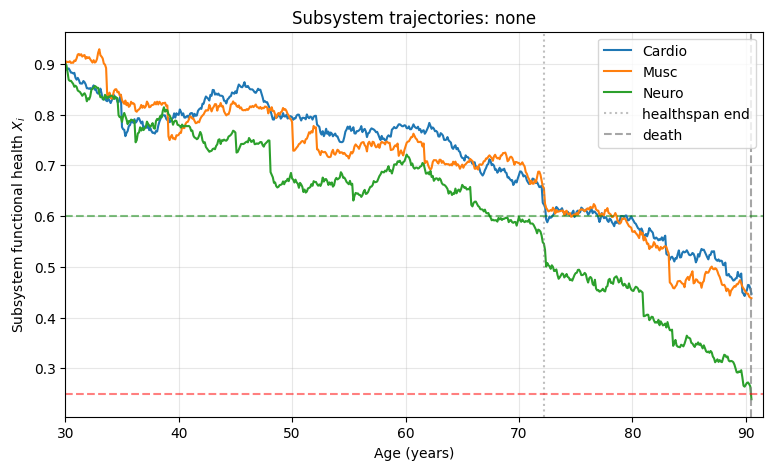

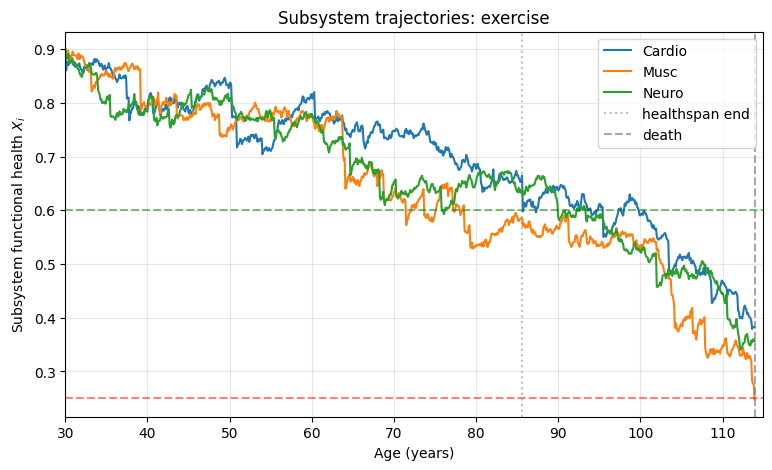

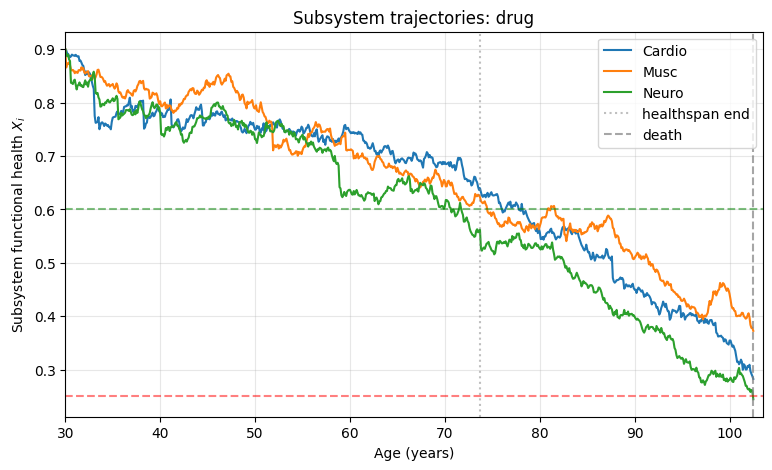

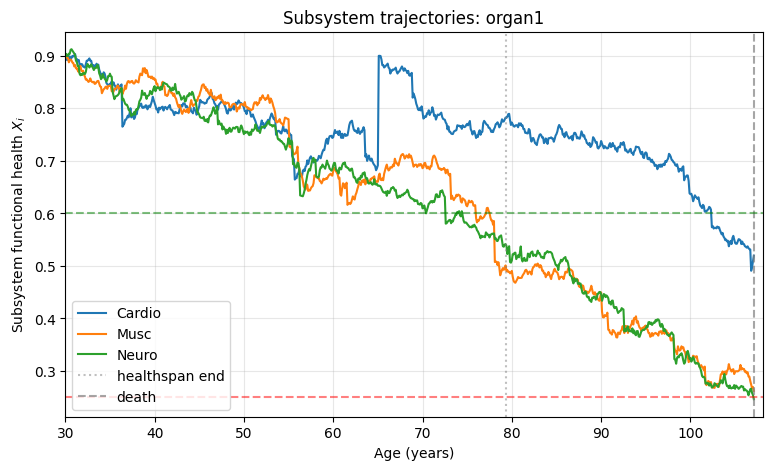

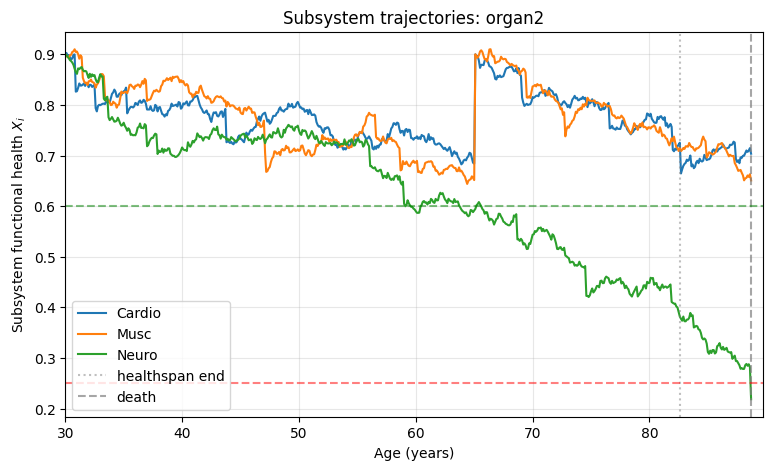

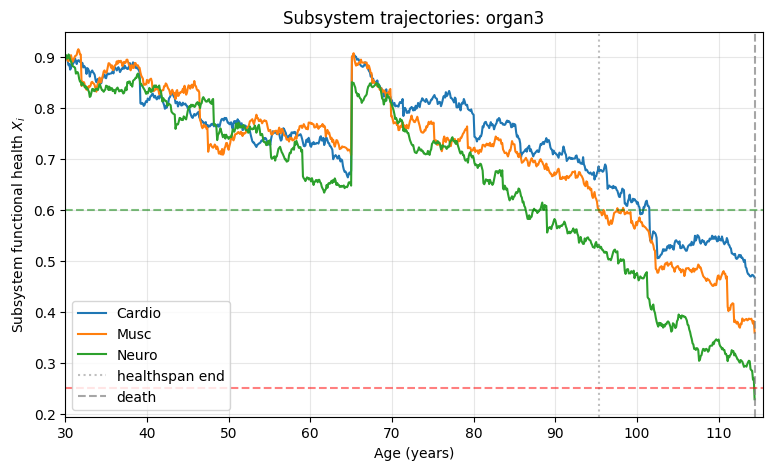

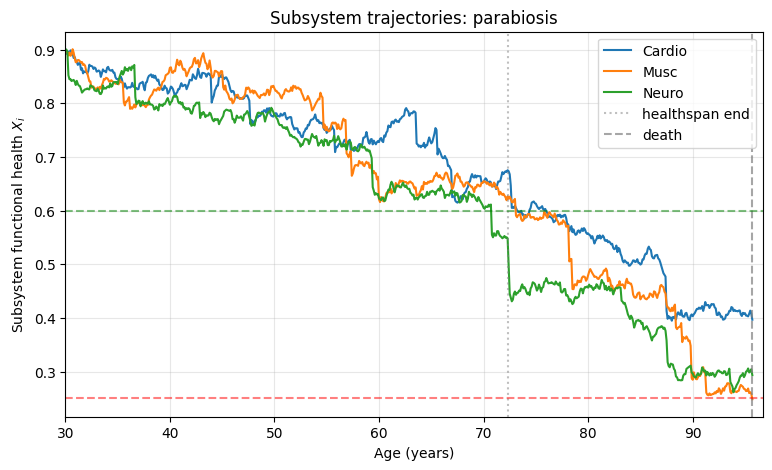

In [6]:

# Subsystem trajectories for each intervention
for mode in DEFAULT_SCENARIOS:
    res = single_results[mode]
    plt.figure(figsize=(9, 5))
    for idx, name in enumerate(node_names):
        plt.plot(res.age, res.X_hist[:, idx], label=name)

    if res.healthspan is not None:
        plt.axvline(res.healthspan, color="gray", linestyle=":", alpha=0.5, label="healthspan end")
    if res.lifespan is not None:
        plt.axvline(res.lifespan, color="gray", linestyle="--", alpha=0.7, label="death")
        plt.xlim(sim_cfg.start_age, res.lifespan + 1.0)
    else:
        plt.xlim(sim_cfg.start_age, sim_cfg.start_age + sim_cfg.years)

    plt.axhline(sim_cfg.func_threshold, color="green", linestyle="--", alpha=0.5)
    plt.axhline(sim_cfg.death_threshold, color="red", linestyle="--", alpha=0.5)
    plt.xlabel("Age (years)")
    plt.ylabel("Subsystem functional health $X_i$")
    plt.title(f"Subsystem trajectories: {mode}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## Cause of death distribution

Monte Carlo estimate of which subsystem most often triggers death in the baseline scenario.

Total deaths: 300/300
  Cardio: 14 (4.67%)
  Musc: 55 (18.33%)
  Neuro: 231 (77.00%)


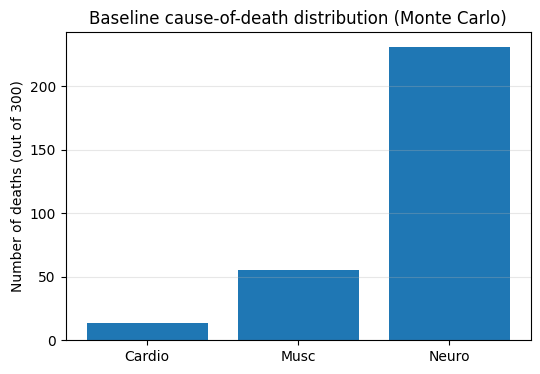

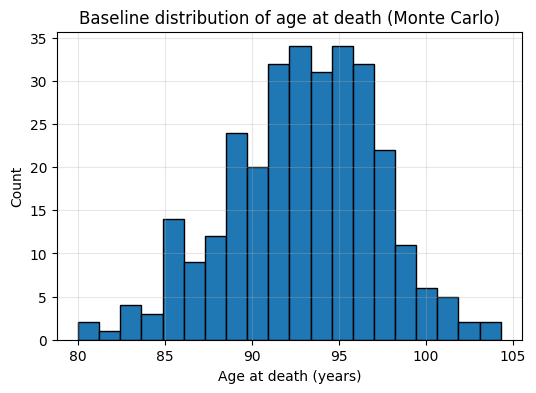

In [7]:

# Monte Carlo cause-of-death distribution for baseline
n_runs = 300
rng = np.random.default_rng(42)
cause_counts = np.zeros(len(node_names), dtype=int)
ages_at_death = []

for _ in range(n_runs):
    seed = int(rng.integers(0, 2**32 - 1))
    res = run_sim("none", sim_config=sim_cfg, system_config=system_cfg, rng_seed=seed)
    if res.cause_of_death is not None and res.lifespan is not None:
        cause_counts[res.cause_of_death] += 1
        ages_at_death.append(res.lifespan)

total_deaths = cause_counts.sum()
print(f"Total deaths: {total_deaths}/{n_runs}")
for idx, name in enumerate(node_names):
    frac = cause_counts[idx] / total_deaths if total_deaths else 0.0
    print(f"  {name}: {cause_counts[idx]} ({frac:.2%})")

plt.figure(figsize=(6, 4))
plt.bar(node_names, cause_counts)
plt.ylabel(f"Number of deaths (out of {n_runs})")
plt.title("Baseline cause-of-death distribution (Monte Carlo)")
plt.grid(axis="y", alpha=0.3)
plt.show()

if ages_at_death:
    plt.figure(figsize=(6, 4))
    plt.hist(ages_at_death, bins=20, edgecolor="black")
    plt.xlabel("Age at death (years)")
    plt.ylabel("Count")
    plt.title("Baseline distribution of age at death (Monte Carlo)")
    plt.grid(alpha=0.3)
    plt.show()


## Healthspan vs lifespan scatter

Monte Carlo scatterplot across interventions.

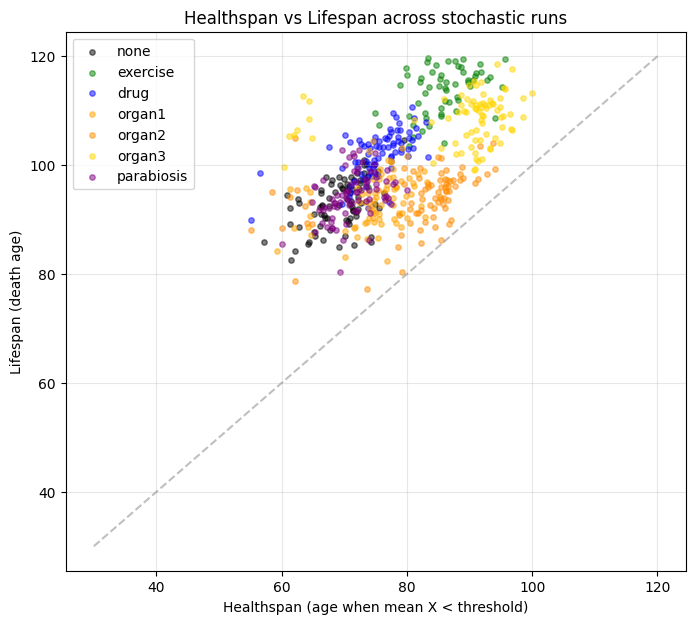

In [8]:

# Monte Carlo healthspan vs lifespan
mc_results = {
    mode: run_many(mode, n_runs=80, sim_config=sim_cfg, system_config=system_cfg)
    for mode in DEFAULT_SCENARIOS
}
plot_healthspan_vs_lifespan(mc_results, config=sim_cfg, color_map=color_map)
plt.show()
